# Extract C II 6462 line from MUSE cube

In [342]:
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import numpy as np
from numpy.polynomial import Chebyshev as T
from scipy.ndimage import median_filter
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

We have two versions of the cont-subtracted MUSE cubes:
* Rebinned 16x16 cubes are from the Raman project
* Full-resolution cubes are too big for Dropbox, so stored elsewhere

In [2]:
RAW_DATA_PATH = Path.home() / "Dropbox" / "dib-scatter-hii" / "data" / "orion-muse"
RAW_BIG_DATA_PATH = Path.home() / "Work" / "Muse-Hii-Data" / "M42"

## First try with the smaller cube

In [12]:
hdu = fits.open(
    RAW_DATA_PATH / "muse-hr-data-wavsec23-rebin16x16-cont-sub.fits"
)["DATA"]

In [13]:
w = WCS(hdu)
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'AWAV'  
CRVAL : 83.780566  -5.396172  5.7884e-07  
CRPIX : 100.875  45.75  1.0  
CD1_1 CD1_2 CD1_3  : -0.00088888888888888  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000888888888888889  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  8.5e-11  
NAXIS : 110  92  1404

### Find the wavelength pixel that corresponds to the rest wavelength of the C II line

AtLL gives 2 components: 6461.95 and 6462.13, with $g_k A_{ki}$-weighted wavelength of 6462.05:

In [95]:
wav0_6462 = 6462.05 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6462))
k0

792

Take a +/- 50 pixel window around rest wavelength pixel:

In [204]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]

Make an array of wavelengths for the entire cube, and then select the wavs of the window

In [205]:
VOMC = 20.0

In [206]:
nwavs, ny, nx = hdu.data.shape
wavs = w.spectral.array_index_to_world(np.arange(nwavs)).Angstrom
wavs *= (1.0 - VOMC / 3e5)
window_wavs = wavs[window_slice]
window_wavs

array([6418.67206   , 6419.52200333, 6420.37194667, 6421.22189   ,
       6422.07183333, 6422.92177667, 6423.77172   , 6424.62166333,
       6425.47160667, 6426.32155   , 6427.17149333, 6428.02143667,
       6428.87138   , 6429.72132333, 6430.57126667, 6431.42121   ,
       6432.27115333, 6433.12109667, 6433.97104   , 6434.82098333,
       6435.67092667, 6436.52087   , 6437.37081333, 6438.22075667,
       6439.0707    , 6439.92064333, 6440.77058667, 6441.62053   ,
       6442.47047333, 6443.32041667, 6444.17036   , 6445.02030333,
       6445.87024667, 6446.72019   , 6447.57013333, 6448.42007667,
       6449.27002   , 6450.11996333, 6450.96990667, 6451.81985   ,
       6452.66979333, 6453.51973667, 6454.36968   , 6455.21962333,
       6456.06956667, 6456.91951   , 6457.76945333, 6458.61939667,
       6459.46934   , 6460.31928333, 6461.16922667, 6462.01917   ,
       6462.86911333, 6463.71905667, 6464.569     , 6465.41894333,
       6466.26888667, 6467.11883   , 6467.96877333, 6468.81871

Look at the average profile

In [262]:
window_norm = window_cube / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

Also calculate the sky profile, since I am now convinced that most of the other lines are sky.

In [263]:
xskyslice, yskyslice = slice(0, 20), slice(55, 76)
window_sky = np.median(window_norm[:, yskyslice, xskyslice], axis=(1, 2))

Get some potential line IDs from Fang 2011

In [264]:
line_ids = {
    6425.9: "O II",
    6441.295: "[Ni II]",
    6445.81: "Ne II",
#    6451.97: "V II",
    6456.38: "Fe II",
#    6461.95: "C II",
    6462.05: "C II", # mean doublet wavelength
#    6462.13: "C II",
    6466.07: "Fe II",
#    6468.8: "C II",
#    6467.288: "[Ni II]",
#    6469.213: "[Co II]",
    6471.42: "O II",
#    6471.91: "C II",
    6478.72: "N II",
#    6485.2983: "[Fe II]",
#    6483.97: "O II",
#    6485.06: "O II",
#    6491.91: "O II",
    6481.706: " ",
    6482.699: " ",
    6483.753: "N I",
    6484.808: " ",
#    6491.222: "N I",
#    6499.518: " ",
    6501.41: "O II",
#    6506.302: "N I",
#    6507.024: "",
#    6521.110: "N I",
}

In [265]:
def wav2k(wav):
    return w.spectral.world_to_array_index(
         np.asarray(wav) * u.Angstrom
    )

def k2wav(k):
    if len(k):
        return w.spectral.array_index_to_world(
            np.atleast_1d(k)
        ).Angstrom
    else:
        return np.array([])

In [266]:
wav2k(list(line_ids.keys()))

array([750, 768, 773, 786, 793, 797, 804, 812, 816, 817, 818, 819, 839])

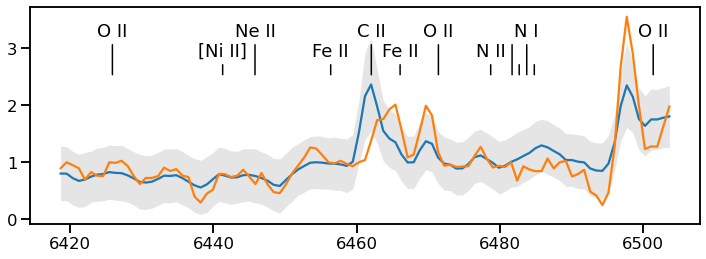

In [267]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_sky)
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 2.5), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1
    

Now try subtracting the average sky spectrum:

In [268]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

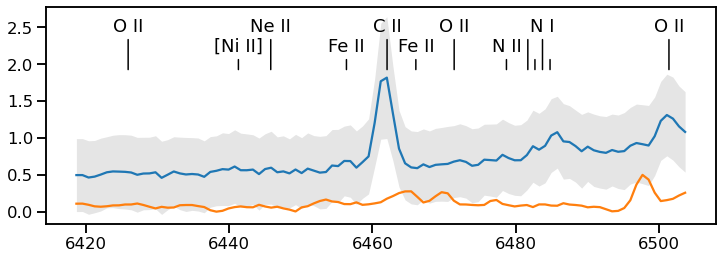

In [269]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, 0.5 * sky[:, 0, 0] / np.max(sky))
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 1.9), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1
    

Yes, that looks a lot better!  So most of the line IDs are not detected at all. It looks very clean around the C II line, with the possible exception of Fe II.  Then, to the red we have a possible detection of the N I multiplet at 6485 and O II at 6502

Now plot against array index 

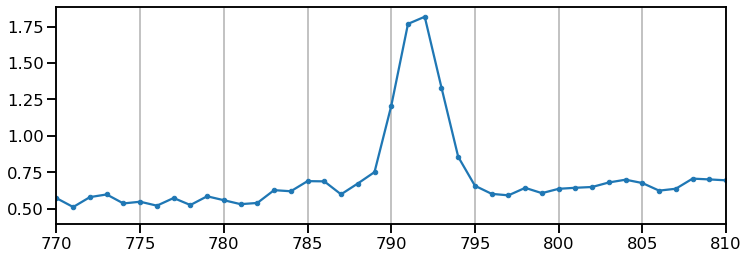

In [270]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.set(
    xlim=[770, 810],
)
ax.grid(axis="x")

770-787 blue continuum. 

796-810 red continuum 

788-795 covers the line

Try it out:

In [279]:
myav = np.mean
fullsky = myav(
    hdu.data[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
fullcube_nosky = hdu.data - fullsky
cont_map_blue = myav(fullcube_nosky[770:788, ...], axis=0)
cont_map_red = myav(fullcube_nosky[796:810, ...], axis=0)
cont_map = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
cii_map = (fullcube_nosky[788:796, ...] - cont_map).sum(axis=0)

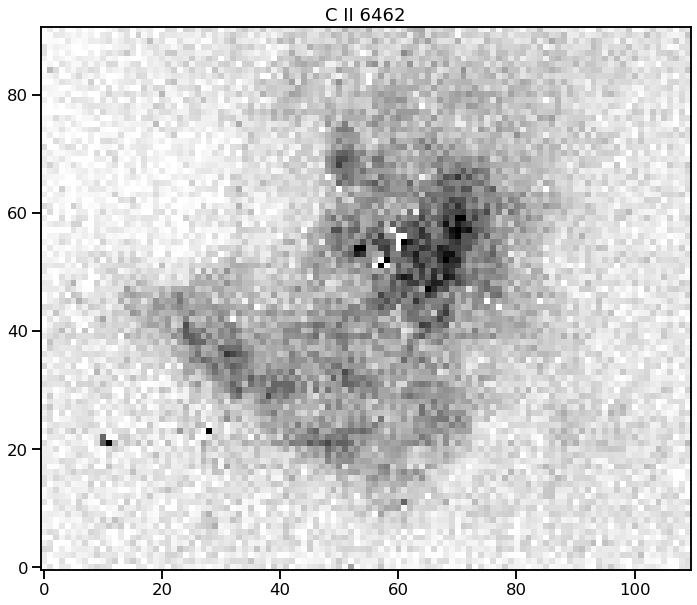

In [288]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii_map, vmin=-3e4, vmax=6e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

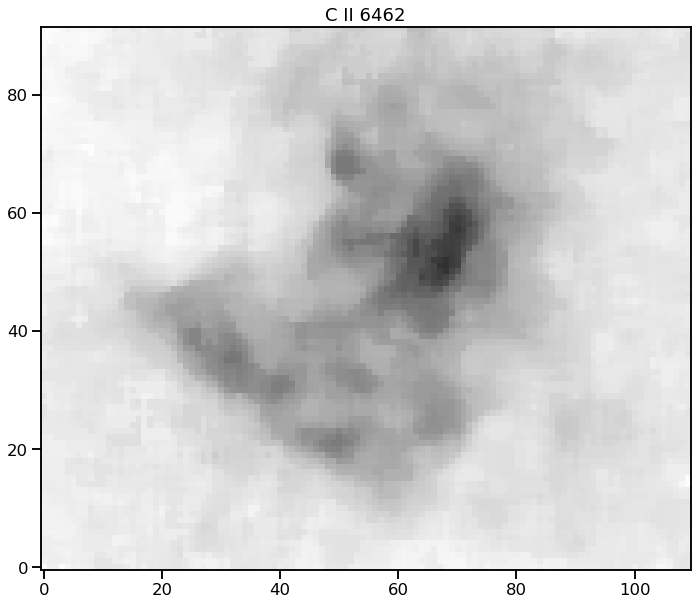

In [355]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 5
ax.imshow(
    median_filter(cii_map, size=smooth), 
    vmin=-3e4, vmax=6e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

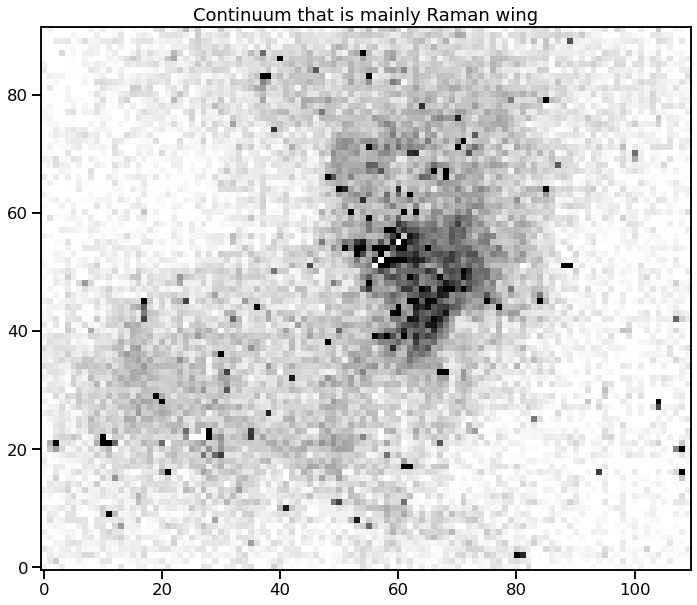

In [286]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map, vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

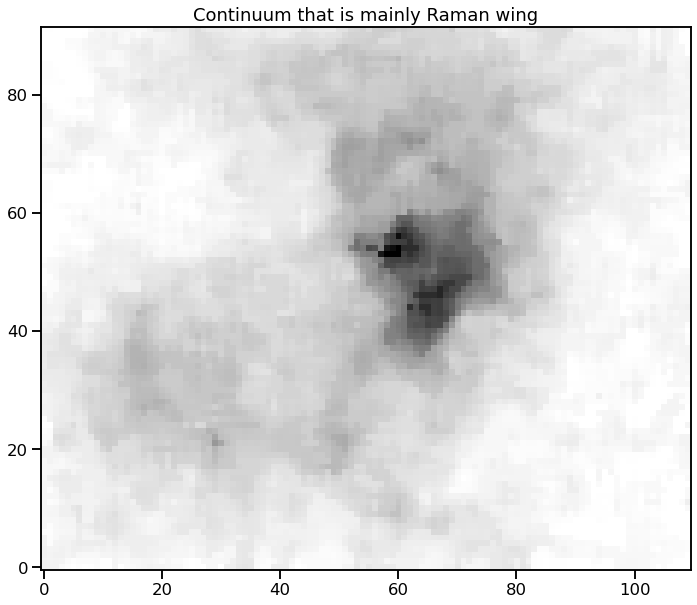

In [365]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 4
ax.imshow(
    median_filter(cont_map, size=smooth), 
    vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

## Compare with H alpha

In [289]:
wav0_6563 = 6562.79 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6563))
k0

911

In [290]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]
window_wavs = wavs[window_slice]
window_wavs

array([6519.81531667, 6520.66526   , 6521.51520333, 6522.36514667,
       6523.21509   , 6524.06503333, 6524.91497667, 6525.76492   ,
       6526.61486333, 6527.46480667, 6528.31475   , 6529.16469333,
       6530.01463667, 6530.86458   , 6531.71452333, 6532.56446667,
       6533.41441   , 6534.26435333, 6535.11429667, 6535.96424   ,
       6536.81418333, 6537.66412667, 6538.51407   , 6539.36401333,
       6540.21395667, 6541.0639    , 6541.91384333, 6542.76378667,
       6543.61373   , 6544.46367333, 6545.31361667, 6546.16356   ,
       6547.01350333, 6547.86344667, 6548.71339   , 6549.56333333,
       6550.41327667, 6551.26322   , 6552.11316333, 6552.96310667,
       6553.81305   , 6554.66299333, 6555.51293667, 6556.36288   ,
       6557.21282333, 6558.06276667, 6558.91271   , 6559.76265333,
       6560.61259667, 6561.46254   , 6562.31248333, 6563.16242667,
       6564.01237   , 6564.86231333, 6565.71225667, 6566.5622    ,
       6567.41214333, 6568.26208667, 6569.11203   , 6569.96197

In [291]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

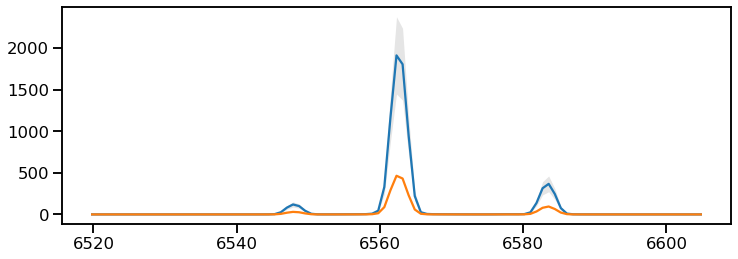

In [294]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_mad)

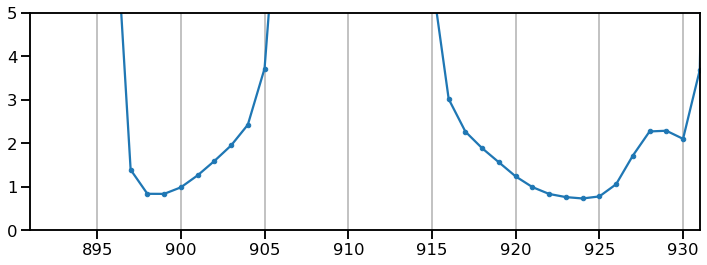

In [300]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.set(
    xlim=[k0 - 20, k0 + 20],
    ylim=[0, 5],
)
ax.grid(axis="x")

In [307]:
cont_map_blue = myav(fullcube_nosky[898:901, ...], axis=0)
cont_map_red = myav(fullcube_nosky[922:925, ...], axis=0)
cont_map_ha = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
ha_map = (fullcube_nosky[906:916, ...] - cont_map_ha).sum(axis=0)

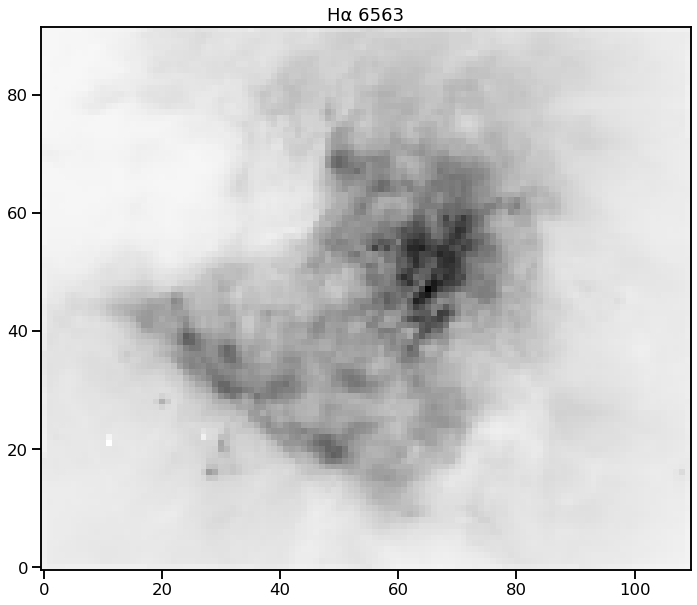

In [308]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(ha_map, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563");

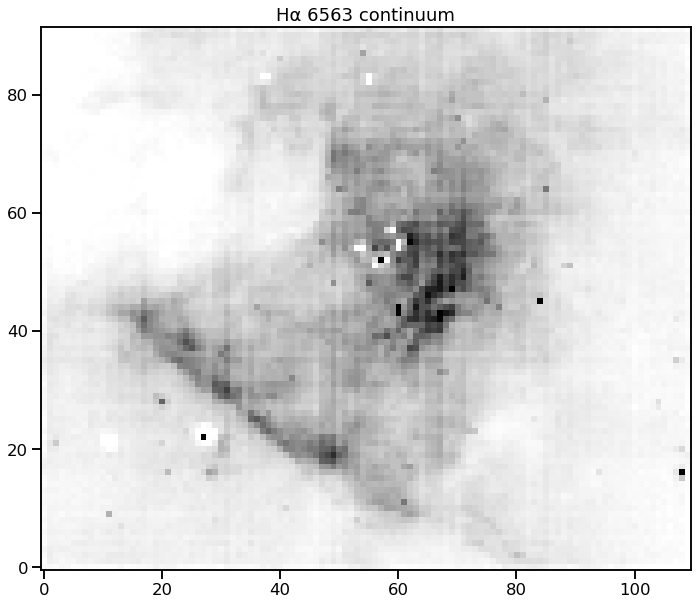

In [310]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map_ha, vmin=0, vmax=1e6, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563 continuum");

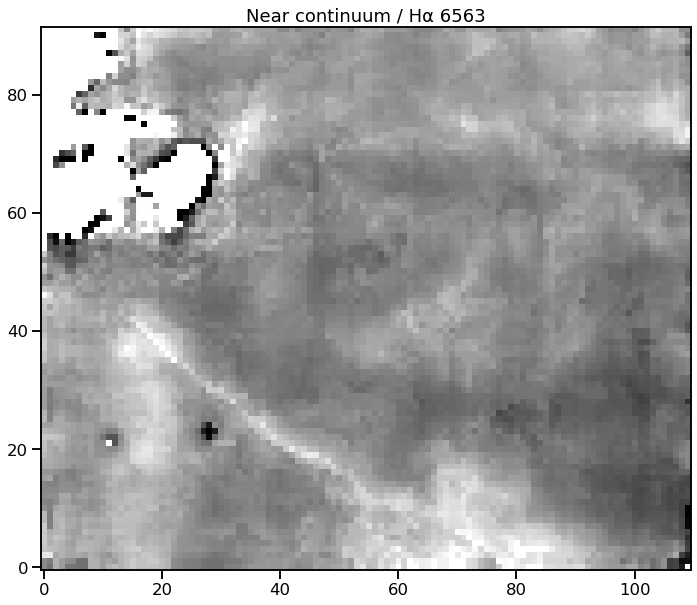

In [388]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.01 * np.median(ha_map)
smooth = 4
ratio = (
    median_filter(cont_map_ha, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=0, 
    vmax=2.5e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("Near continuum / Hα 6563");

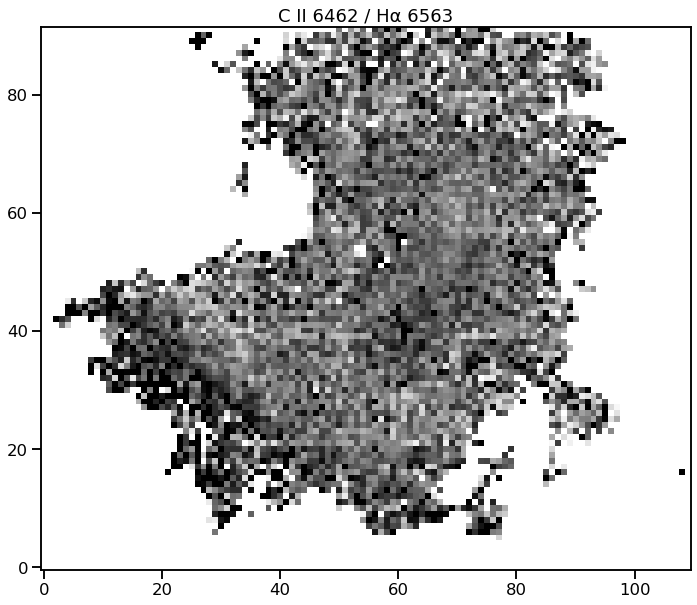

In [341]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 1 * np.median(ha_map)
ratio = cii_map / ha_map
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("C II 6462 / Hα 6563");

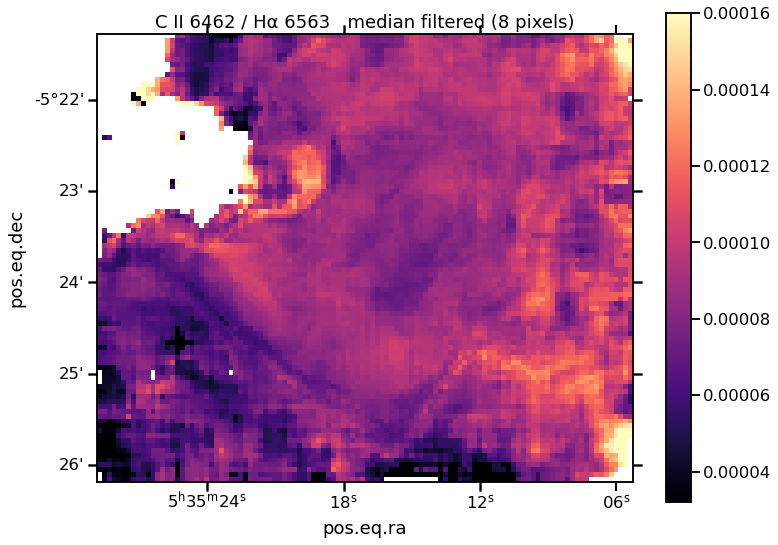

In [372]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=w.celestial),
)
mask = ha_map < 0.2 * np.median(ha_map)
smooth = 8
ratio = (
    median_filter(cii_map, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="magma",
)
fig.colorbar(im, ax=ax)
ax.set_title(f"C II 6462 / Hα 6563   median filtered ({smooth} pixels)");

So the typical value is 1e-4.  We can estimate the C++/H+ abundance by looking at the effective recombination rates.

## Now try and extract 6578

Make use of the sky-subtracted cube that we already have.  Extract a wide-ish window centered on the Ha line since we want to have a food sampling of the two [N II] lines and of the Ha wings:

In [515]:
NWIN = 160
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))

Find the shift in wav pixels between the two [N II] lines.

In [536]:
wav0_6548 = 6548.05 * u.Angstrom
wav0_6583 = 6583.45 * u.Angstrom
k0_6548 = w.spectral.world_to_pixel(wav0_6548)
k0_6583 = w.spectral.world_to_pixel(wav0_6583)
k0_6548, k0_6583

(array(893.70588235), array(935.35294118))

In [537]:
kshift = k0_6583 - k0_6548
kshift

41.64705882352928

Range of wav pixels for the window centered on Ha, and also for the full cube:

In [538]:
kwindow = wav2k(window_wavs)
kfull = np.arange(nwavs)

We fit two polynomials to the Ha wings: 
* `p` is fitted to the blue wing and is subtracted from the 6548 profile before shifting it. 
* `p2` is fitted to the red wing and is directly subtracted from the C II profile. 

In [539]:
p1 = T.fit(kwindow[:45], window_median[:45], deg=2)
p2 = T.fit(kwindow[-40:], window_median[-40:], deg=2)

We will use the same shape of polynomial for all pixels, so we don't have to do lots of fitting, which would be slow.

We calculate the median of the ratio of the true wing to the polynomial, which we will use for scaling it. This is about 96% in the blue wing becaouse it cuts out all teh faint lines, which had pulled up the fit a bit. 

In [540]:
fac1 = np.median(window_median[:45] / p1(kwindow[:45]))
fac2 = np.median(window_median[-40:] / p2(kwindow[-40:]))
fac1, fac2

(0.9538885081159763, 0.9914327531545049)

Make a version of the wing-subtracted 6548 profile that is shifted and interpolated to account for the wavelength difference between 6548 and 6583. We multiply by 3 to account for the A ratio and only subtract scale factor times the polynomial.

In [541]:
nii_A_ratio = 2.95765481
window_shift = np.interp(
    kwindow, 
    kwindow + kshift,
    nii_A_ratio * (window_median - fac1 * p1(kwindow)),
)

The linear interpolation causes a small amount of smoothing.  Therefore, we must also apply smoothing to the original profile, otherwise we will get ringing artefacts when we do the subtraction.  I use a 3-pixel peaked kernel that sums to 1, where `delta` is the relative height of the "wing" pixels, which I determine by trial and error. 

In [548]:
from scipy.ndimage import convolve
delta = 0.095
kernel = np.array([delta, 1.0 - 2 * delta, delta])
window_median_smooth = convolve(window_median, kernel)

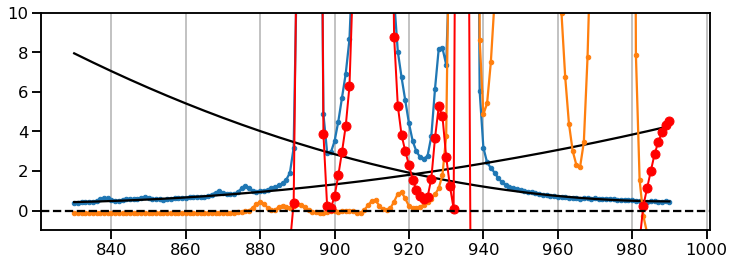

In [549]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwindow, window_median, marker=".")
ax.plot(kwindow, fac1 * p1(kwindow), color="k")
ax.plot(kwindow, fac2 * p2(kwindow), color="k")
ax.plot(kwindow, window_shift, marker=".")
ax.plot(
    kwindow, 
    window_median_smooth - window_shift - fac2 * p2(kwindow), 
    marker="o", color="r", lw=2)

ax.axhline(0.0, color="k", linestyle="dashed")
ax.set(
    xlim=[k0 - 90, k0 + 90],
    ylim=[-1, 10],
)
ax.grid(axis="x")

Here I plot the following: 
* original profile in blue
* fitted and scaled wings in black
* shifted and scaled interpolated 6548 profile in orange
* smoothed blue minus orange in red – this should give the isolated C II profile

In [550]:
wav0_6578 = 6578.05 * u.Angstrom
k0_6578 = w.spectral.world_to_pixel(wav0_6578)
k0_6578

array(929.)

Zoom in on the 6578 line:

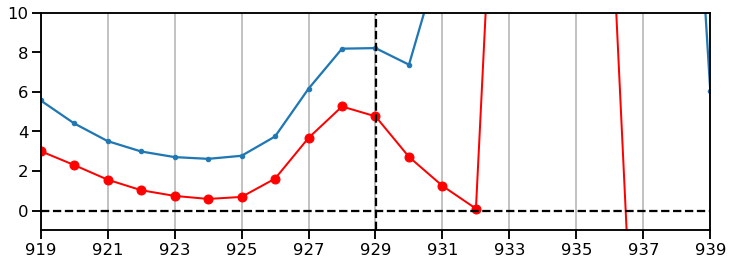

In [551]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwindow, window_median, marker=".")
ax.plot(
    kwindow, 
    window_median_smooth - window_shift - fac2 * p2(kwindow), 
    marker="o", color="r", lw=2)

ax.axhline(0.0, color="k", linestyle="dashed")
ax.axvline(k0_6578, color="k", linestyle="dashed")
ax.set(
    xlim=[k0_6578 - 10, k0_6578 + 10],
    ylim=[-1, 10],
    xticks=range(int(k0_6578) - 10, int(k0_6578) + 11, 2),
)
ax.grid(axis="x")

So it looks like pixels 925–932 span the entire line. However, at 931 the C II contribution is only 10% of the total, so there will be lots of noise.  And at 932 the C II contribution is essentially zero and the [N II] contamination is enormous. 

### Now apply the same procedure pixel-by-pixel.

First, do the wings:

In [552]:
fac1 = np.median(
    window_cube[:45, ...] / p1(kwindow[:45])[:, None, None],
    axis=0,
)
fac2 = np.median(
    window_cube[-40:, ...] / p2(kwindow[-40:])[:, None, None],
    axis=0,
)

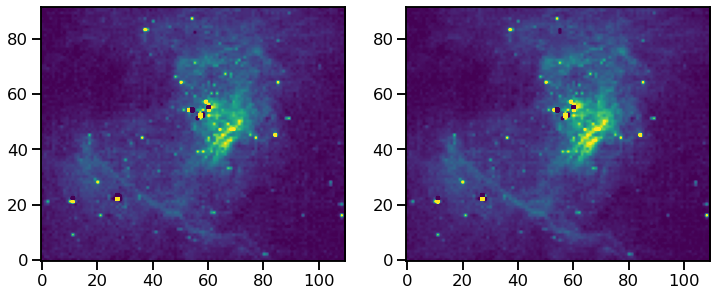

In [553]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(fac1, vmin=-1e4, vmax=4e5, origin="lower")
ax2.imshow(fac2, vmin=-1e4, vmax=4e5, origin="lower")

**Wow, these are good images of the Raman wings!** *They look much better than the ones in my paper!*

Now do the shift of the wing-subtracted 6548 line. We have to use the scipy function because the numpy one does not support interpolation along one axis of a multidimensional array. We still  do a linear interpolation though because the data are too noisy to support anything fancy like spline. 

In [556]:
from scipy.interpolate import interp1d

interpolator = interp1d(
    kwindow + kshift,
    nii_A_ratio * (
        window_cube 
        - fac1[None, :, :] * p1(kwindow)[:, None, None]
    ),
    axis=0,
    kind="linear",
    fill_value="extrapolate",
)
window_shift = interpolator(kwindow)

Do the smoothing of the original cube. We need to reshape the kernel to make it 3-dimensional. 

In [557]:
window_cube_smooth = convolve(window_cube, kernel.reshape((3, 1, 1)))

Find pixel offset of window from start of wav axis

In [559]:
kw0 = kwindow[0]
kw0

830

Subtract the shifted 6548 line and the red wing from the smoothed cube. Then sum up the wav pixels that bracket the C II line:

In [561]:
window_cube_extract = (
    window_cube_smooth 
    - window_shift
    - fac2[None, :, :] * p2(kwindow)[:, None, None]
)
cii6578_map = np.sum(
    window_cube_extract[925 - kw0:932 - kw0, ...],
    axis=0,
)

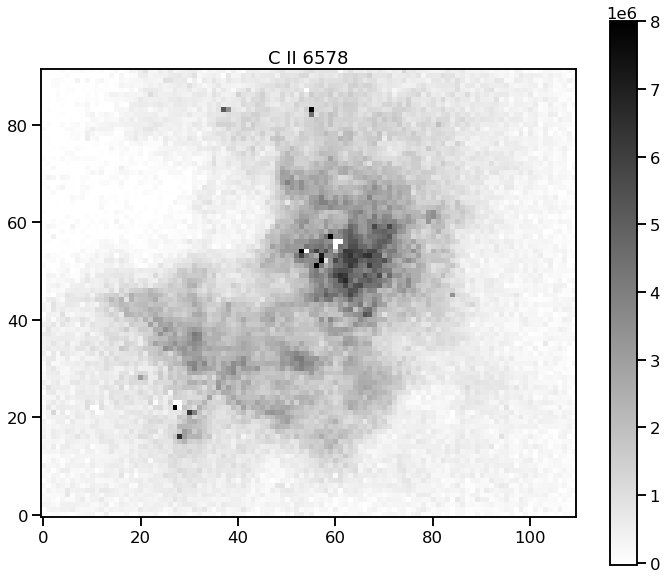

In [577]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(cii6578_map, vmin=-3e4, vmax=8e6, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578");

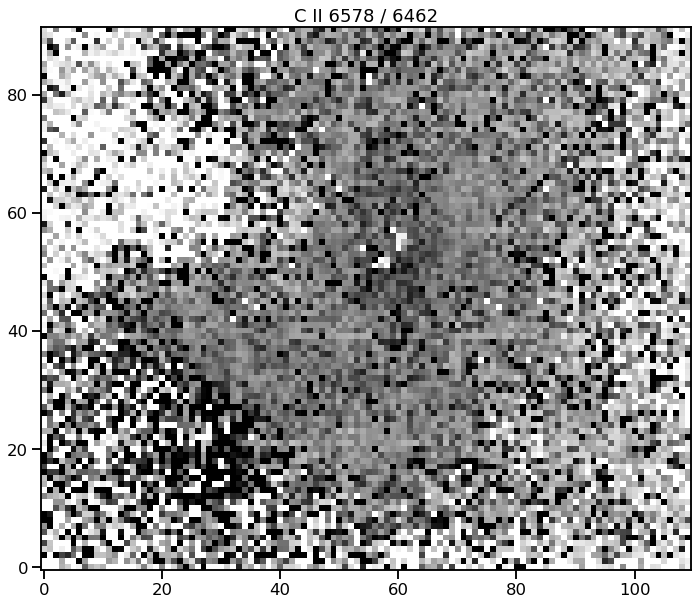

In [566]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii6578_map / cii_map, vmin=-0.5, vmax=20, origin="lower", cmap="gray_r")
ax.set_title("C II 6578 / 6462");

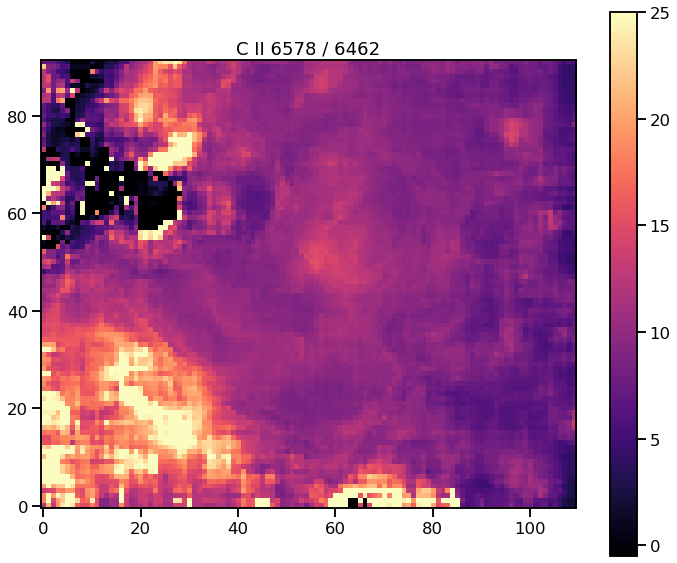

In [570]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.6 * np.median(ha_map)
smooth = 8
ratio = (
    median_filter(cii6578_map, size=smooth) 
    / median_filter(cii_map, size=smooth)
)
im = ax.imshow(ratio, vmin=-0.5, vmax=25, origin="lower", cmap="magma")
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578 / 6462");

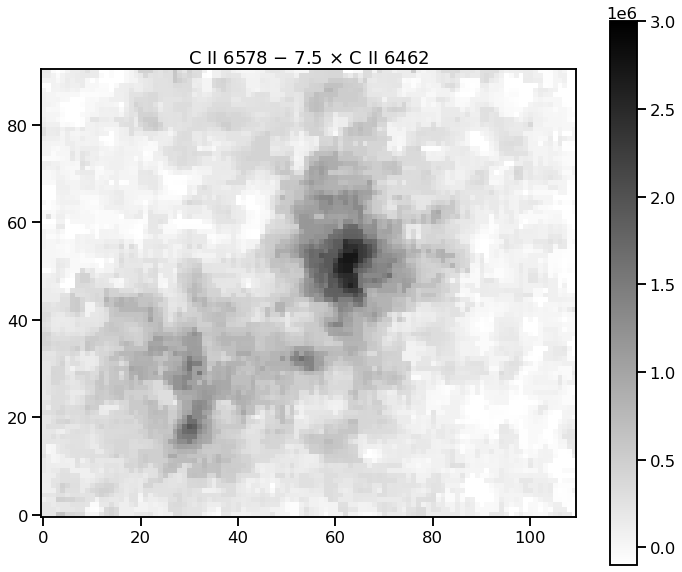

In [599]:
fig, ax = plt.subplots(figsize=(12,10))
FACTOR = 7.5
excess = cii6578_map - FACTOR * cii_map
im = ax.imshow(median_filter(excess, size=4), vmin=-1e5, vmax=3e6, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_title(fr"C II 6578 $-$ {FACTOR} $\times$ C II 6462");

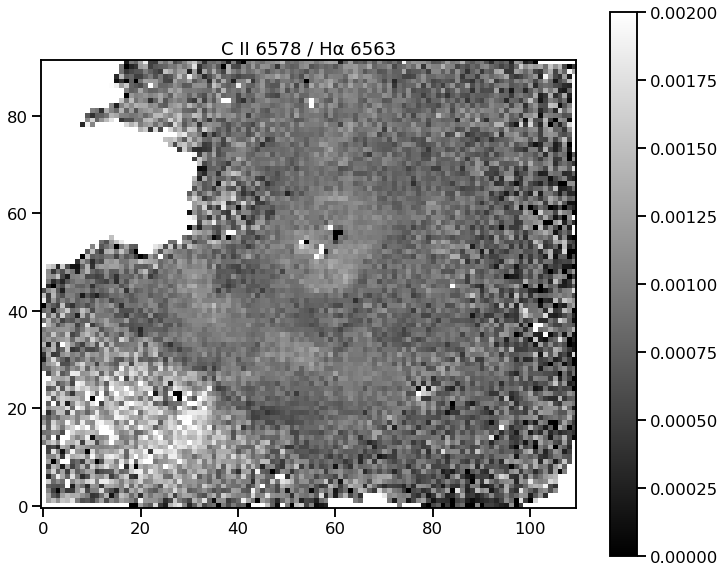

In [583]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.3 * np.median(ha_map)
ratio = cii6578_map / ha_map
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=0, 
    vmax=0.002, 
    origin="lower", 
    cmap="gray",
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578 / Hα 6563");

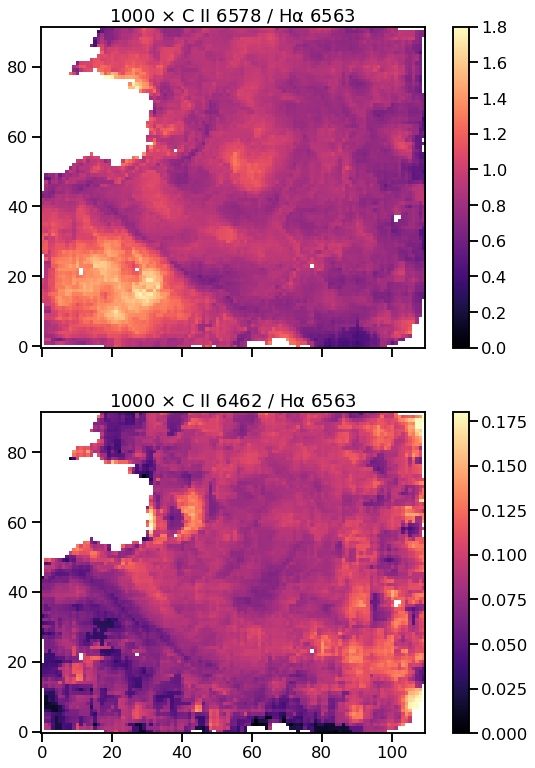

In [615]:
fig, [ax1, ax2] = plt.subplots(
    2, 1, 
    figsize=(10, 13),
    sharex=True,
)

mask = ha_map < 0.3 * np.median(ha_map)

SCALE = 1000
cmap = "magma"
smooth = 6

ratio1 = (
    median_filter(cii6578_map, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio1[mask] = np.nan
im1 = ax1.imshow(
    SCALE * ratio1, 
    vmin=0, 
    vmax=SCALE * 0.0018, 
    origin="lower", 
    cmap=cmap,
)
fig.colorbar(im1, ax=ax1)
ax1.set_title(fr"{SCALE} $\times$ C II 6578 / Hα 6563")

ratio2 = (
    median_filter(cii_map, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio2[mask] = np.nan
im2 = ax2.imshow(
    SCALE * ratio2, 
    vmin=0, 
    vmax=SCALE * 0.00018, 
    origin="lower", 
    cmap=cmap,
)
fig.colorbar(im2, ax=ax2)
ax2.set_title(fr"{SCALE} $\times$ C II 6462 / Hα 6563")
...;

# Look at the excited-core lines: 6780 and 6787

Transition is 2s 2p ($^3$P$_o$) 3s $^4$P$_o$– 2s 2p ($^3$P$_o$) 3p $^4$D.  Note that the quartet state (S = 3/2) is taking into account all 3 electrons.

```
Atomic Line List version: 3.00b4   Constructed: 2021-07-21 14:47 GMT
Wavelength range: 0 - inf   Unit: Angstrom   Type: Air
Radial velocity: 0 km/s
Element/Spectrum: C  II

-LAB-WAVL-ANG-AIR-|-DLAM--|-SPC-|TT|--------CONFIGURATION--------|-TERM--|-J_i-J_k-|--A_ki---|-TPF-|-LEVEL-ENERGY--CM^-1-|-REF---|
   6779.94         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 5/2 2.500e+07    24 166990.73 - 181736.05 ASD
   6780.59         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  1/2 - 3/2 1.490e+07    24 166967.13 - 181711.03 ASD
   6783.91         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 7/2 3.540e+07    24 167035.71 - 181772.41 ASD
   6787.21         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  1/2 - 1/2 2.950e+07    24 166967.13 - 181696.66 ASD
   6791.47         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 3/2 1.870e+07    24 166990.73 - 181711.03 ASD
   6798.10         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 1/2 5.800e+06    24 166990.73 - 181696.66 ASD
   6800.69         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 5/2 1.040e+07    24 167035.71 - 181736.05 ASD
   6812.28         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 3/2 1.710e+06    24 167035.71 - 181711.03 ASD

gk*Aki weighted average wavelength:    6785.85      
```

# Compare with the redder lines: 3d-3p $\lambda\lambda$7231, 7236

Note that the N III 4634, 4641, 4642 lines are the exact equivalent of these.  So they are probably also fluorescently excited. The equivalent of 6578 is 4097, 4103. There is also a pure recomb (presumably) line at 4379 (4f – 5g) and 3999, 4004 (4d – 5f).  

In [617]:
DATA_PATH = Path.cwd().parent / "data" 
cii7236_hdu = fits.open(
    DATA_PATH / "orig-muse" / "linesum-C_II-7236-bin016.fits"
)["SCALED"]

In [618]:
WCS(cii7236_hdu.header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.780566  -5.396172  
CRPIX : 1606.5  724.5  
PC1_1 PC1_2  : -5.55555555556e-05  0.0  
PC2_1 PC2_2  : 0.0  5.55555555556e-05  
CDELT : 1.0  1.0  
NAXIS : 1792  1536

In [619]:
cii7236_map = cii7236_hdu.data

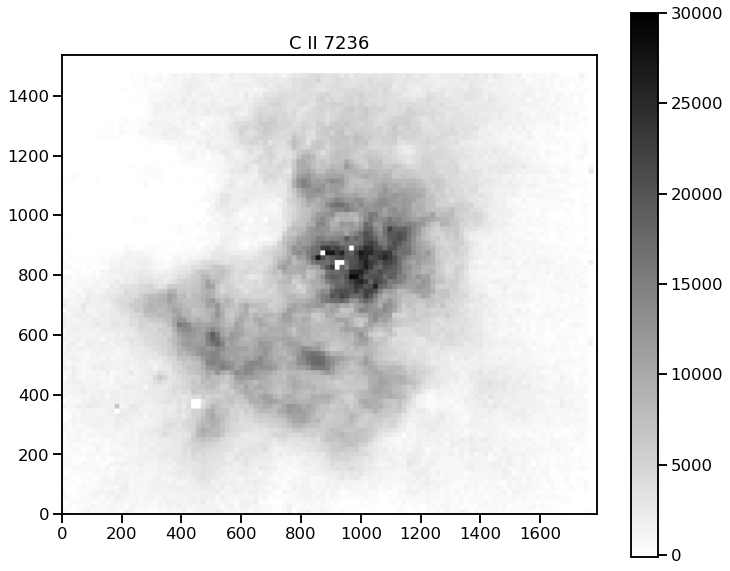

In [622]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(cii7236_map, vmin=-1e2, vmax=3e4, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_title("C II 7236");

In [623]:
ha_map2 = fits.open(
    DATA_PATH / "orig-muse" / "linesum-H_I-6563-bin016.fits"
)["SCALED"].data

In [638]:
xslice, yslice = slice(0, 400), slice(900, 1200)
sky7236 = np.median(cii7236_map[yslice, xslice])
sky7231 = np.median(cii7231_map[yslice, xslice])

<ipython-input-639-a797bad09fc9>:3: RuntimeWarning: divide by zero encountered in true_divide
  (cii7236_map - sky7236)/ ha_map2,


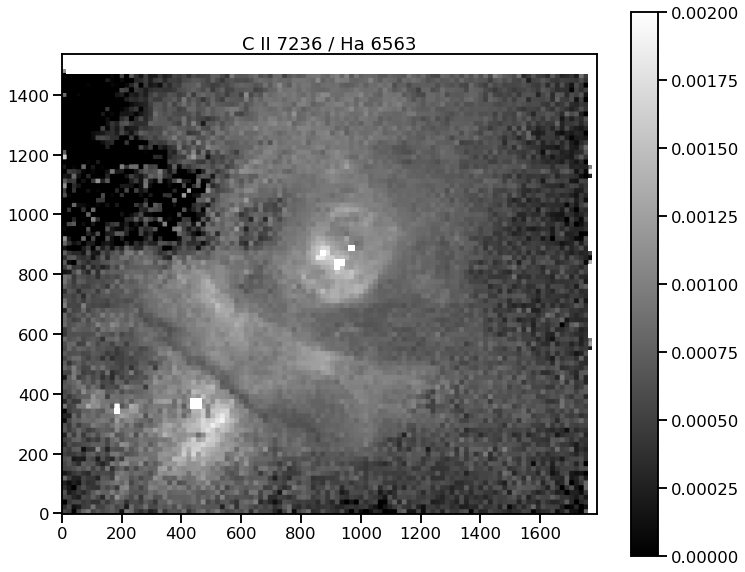

In [639]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(
    (cii7236_map - sky7236)/ ha_map2, 
    vmin=0.0, vmax=0.002, 
    origin="lower", 
    cmap="gray"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7236 / Ha 6563");

In [626]:
cii7231_map = fits.open(
    DATA_PATH / "orig-muse" / "linesum-C_II-7231-bin016.fits"
)["SCALED"].data

<ipython-input-640-e1a14273a401>:3: RuntimeWarning: divide by zero encountered in true_divide
  (cii7231_map - sky7231) / ha_map2,


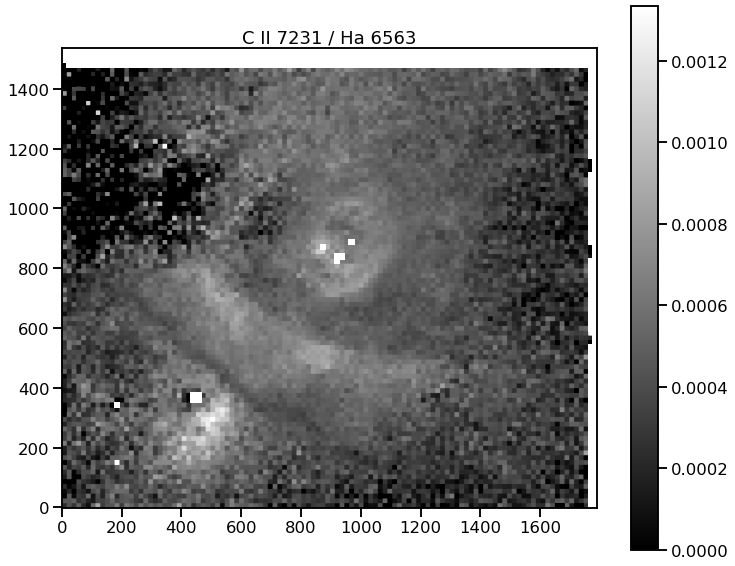

In [640]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(
    (cii7231_map - sky7231) / ha_map2, 
    vmin=0.0, vmax=0.002 * 2/3, 
    origin="lower", 
    cmap="gray"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7231 / Ha 6563");

<ipython-input-652-7e4530b55c65>:8: RuntimeWarning: divide by zero encountered in true_divide
  medfilt2d(cii7231_map - sky7231, 16 * smooth + 1)
<ipython-input-652-7e4530b55c65>:8: RuntimeWarning: invalid value encountered in true_divide
  medfilt2d(cii7231_map - sky7231, 16 * smooth + 1)


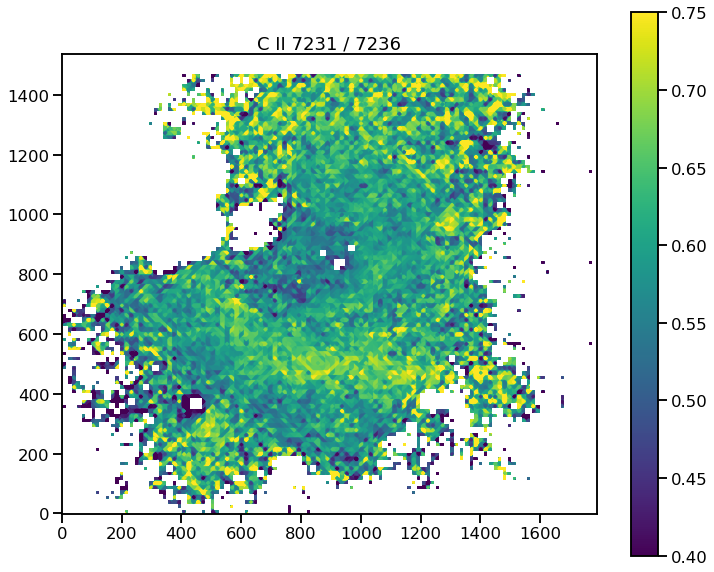

In [652]:
from scipy.signal import medfilt2d

fig, ax = plt.subplots(figsize=(12,10))

mask =  cii7236_map < 0.8 * np.median(cii7236_map)
smooth = 1
ratio = (
    medfilt2d(cii7231_map - sky7231, 16 * smooth + 1) 
    / medfilt2d(cii7236_map - sky7236, 16 * smooth + 1)
)
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=0.4, vmax=0.75, 
    origin="lower", 
    cmap="viridis"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7231 / 7236");

So this is very interesting. The doublet ratio 7231/7236 is not constant. It is roughly 0.5 in the recombination-dominated regions, but is higher than that in some of the fluorescent regions, reaching values > 0.7 in the Big Arc, in the th2A region, and in HH 202. 

This might be related to density or it might be due to the excitation mechanism.  For recombination, there is a critical density above which the multiplet ratios take the LTE values (proportional to statistical weights). 